# Прогнозирование уровня средней заработной платы в России

Данные о среднемесячных уровнях номинальной заработной платы в России - см. [здесь](http://sophist.hse.ru/exes/tables/WAG_M.htm)   
Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import seaborn as sns

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


## 1. Визуальный анализ ряда

Построим график изменения среднемесячной номинальной заработной платы:

In [2]:
df = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

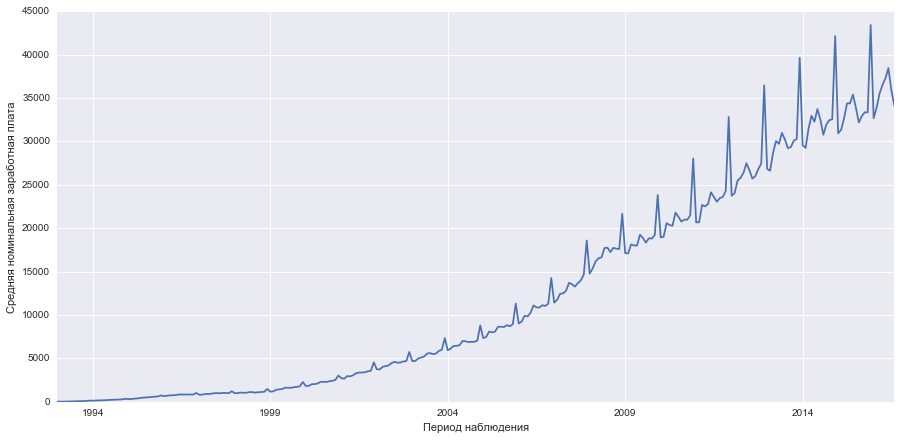

In [34]:
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.ylabel(u'Средняя номинальная заработная плата')
plt.xlabel(u'Период наблюдения')

При этом:

In [45]:
print '1. Минимальная среднемесячная номинальная заработная плата равная {} рублей зафиксирована {}'.format(df[df['WAG_C_M'] == df['WAG_C_M'].min()].values[0, 0],df[df['WAG_C_M'] == df['WAG_C_M'].min()].index[0].date())

1. Минимальная среднемесячная номинальная заработная плата равная 15.3 рублей зафиксирована 1993-01-01


In [46]:
print '2. Максимальная среднемесячная номинальная заработная плата равная {} рублей зафиксирована {}'.format(df[df['WAG_C_M'] == df['WAG_C_M'].max()].values[0, 0],df[df['WAG_C_M'] == df['WAG_C_M'].max()].index[0].date())

2. Максимальная среднемесячная номинальная заработная плата равная 43408.0 рублей зафиксирована 2015-12-01


Проверим стационарность:

In [47]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1]

Критерий Дики-Фуллера: p=0.991850


 Выделим тренд и сезонность:

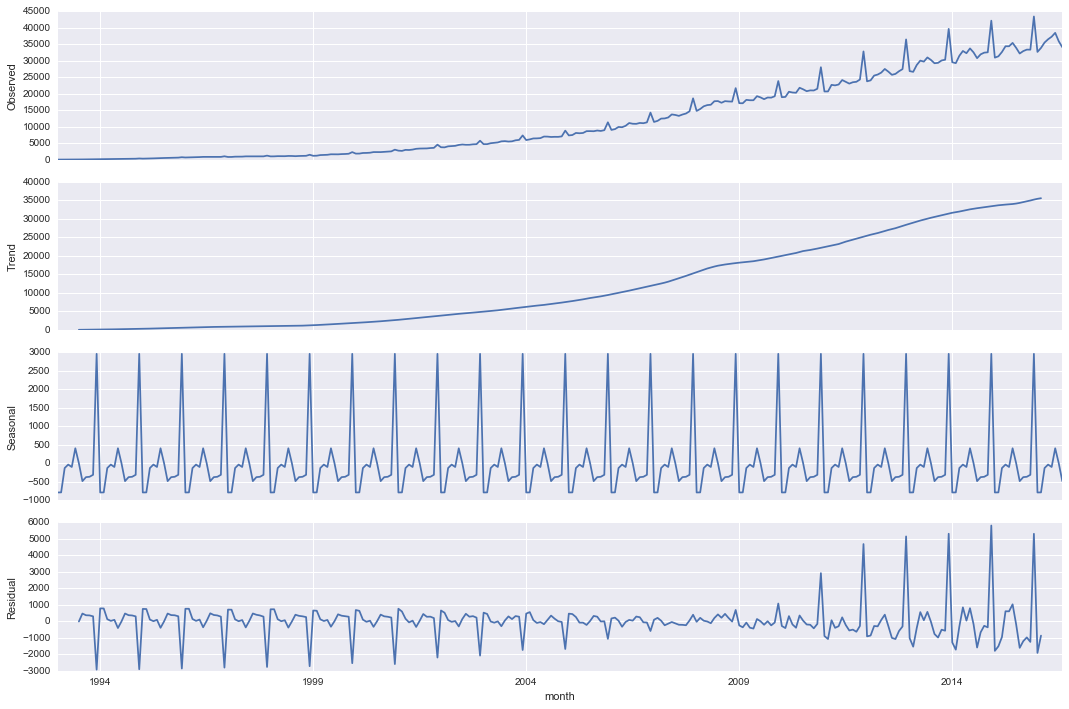

In [49]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
plt.show()

Выявлено:
1. Четко прослеживается тренд: плавное долгосрочное увеличение уровня.     
2. Четко прослеживается сезонность: циклическое изменение уровня с постоянным периодом.   
3. Дисперсия значений в начале значительно меньше дисперсии значений в конце.

Выводы:   
Для построения модели, обощающей временной ряд требуется обеспечить стационарность и для этого необходимо:  
1. Стабилизировать дисперсию в течении всего временного ряда.  
2. Провести дифференцирование (в т.ч. сезонное).    

## Стабизация дисперсии 

Выполним необходимые преобразования и визуализируем временной ряд:

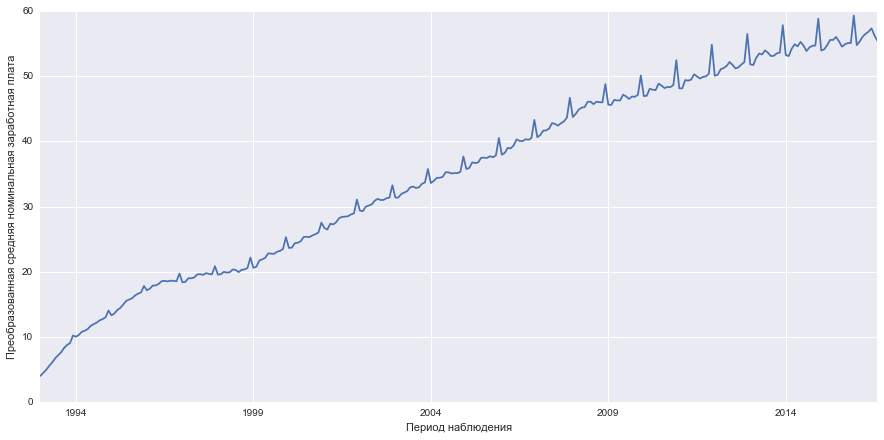

In [53]:
df['WAG_C_M_boxcox'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize(15,7))
df.WAG_C_M_boxcox.plot()
plt.ylabel(u'Преобразованная средняя номинальная заработная плата')
plt.xlabel(u'Период наблюдения')
plt.show()

In [52]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M_boxcox)[1]

Критерий Дики-Фуллера: p=0.696899


Как видно из графика, дисперсия уменьшилась, но стационарность еще не достигнута. Необходимо проводить дифференцирование.

## Дифференцироване временного ряда 

Проведем сначала сезонное дифференцирование и посмотрим на результат:

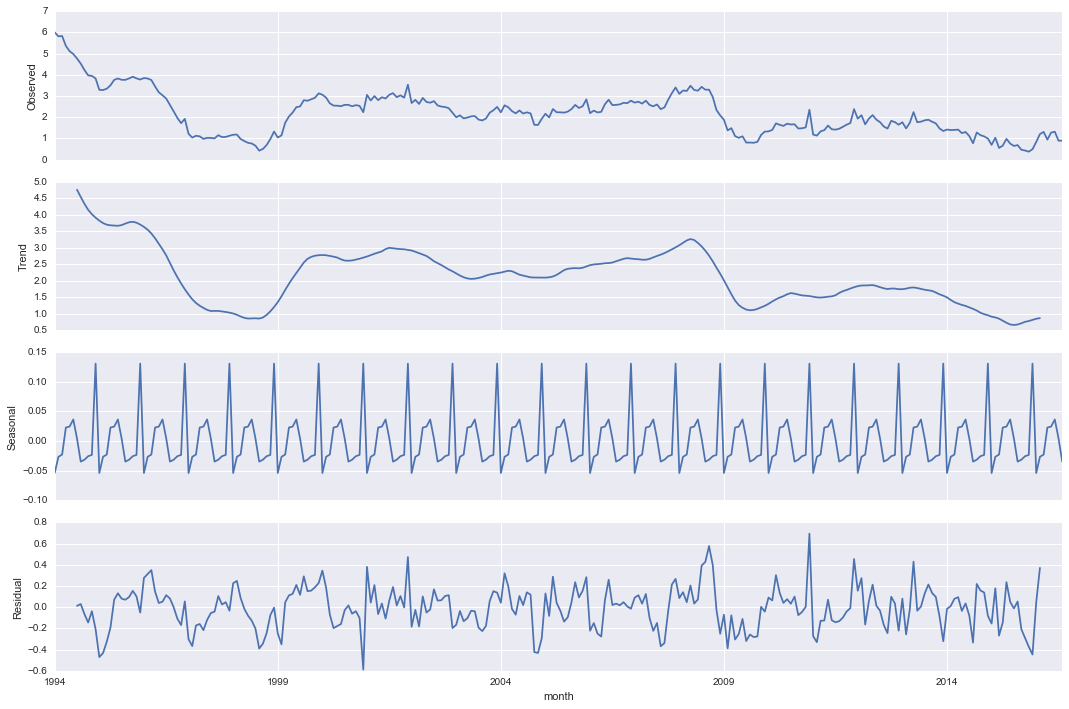

In [55]:
df['WAG_C_M_boxcox_diff'] = df.WAG_C_M_boxcox - df.WAG_C_M_boxcox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M_boxcox_diff[12:]).plot()
plt.show()

In [54]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M_boxcox_diff[12:])[1]

Критерий Дики-Фуллера: p=0.014697


Влияние тренда и сезонных факторов стало пренебрежимо мало. Но несмотря на то, что критерий Дики-Фуллера говорит, что временной ряд стационарен, проведем еще дифференцирование.

Критерий Дики-Фуллера: p=0.000000


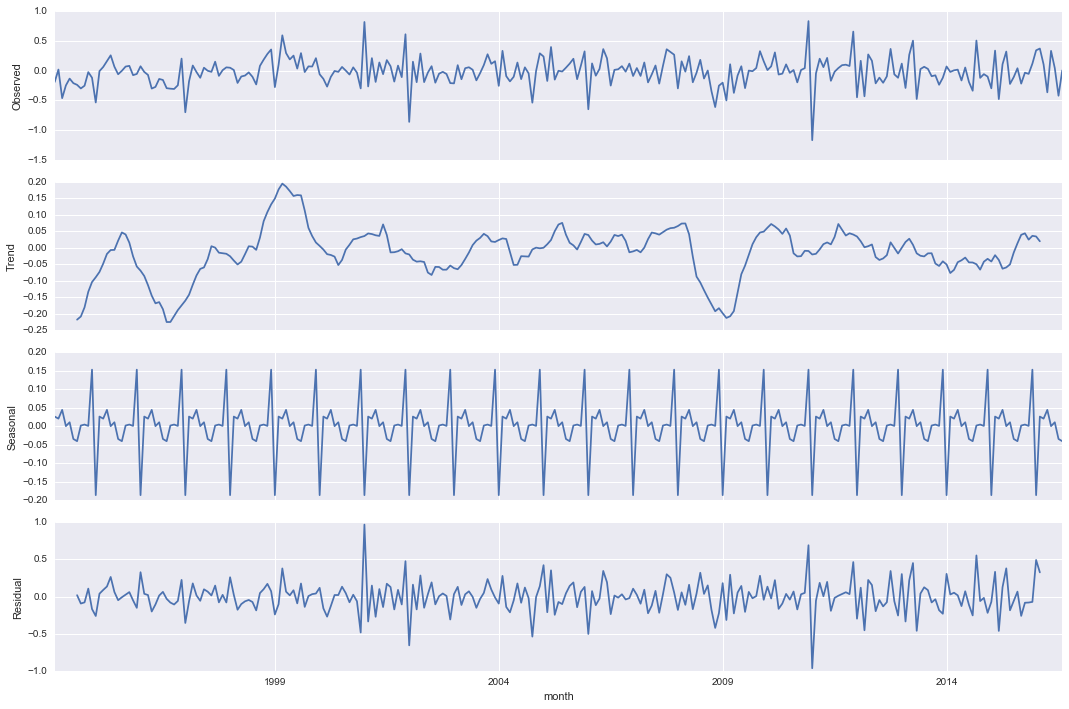

In [51]:
df['WAG_C_M_boxcox_diff12and2'] = df.WAG_C_M_boxcox_diff - df.WAG_C_M_boxcox_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M_boxcox_diff12and2[13:]).plot() 
plt.show()

In [56]:
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M_boxcox_diff12and2[13:])[1]

Критерий Дики-Фуллера: p=0.000000


В итоге еще уменьшили влияние тренда. При этом увеличиловь влияние сезонных факторов, но они остались также пренебреимо малы. 

## Выбор начальных приближений для гиперпараметров модели

Построим необходимые коррелогаммы:

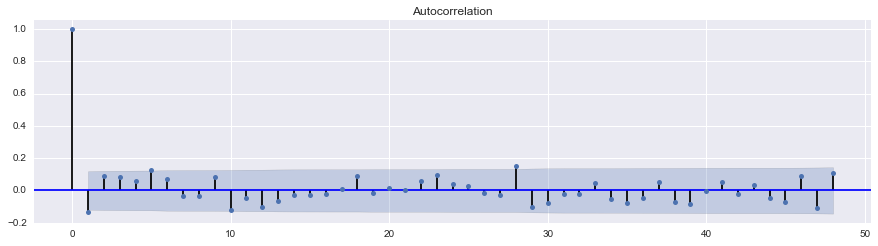

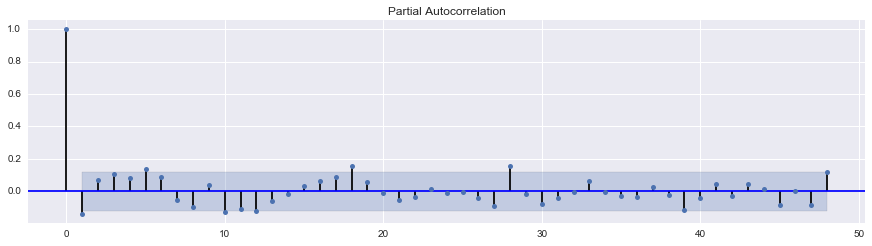

In [13]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.WAG_C_M_boxcox_diff12and2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.WAG_C_M_boxcox_diff12and2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Из графиков выше получены следующие начальные приближения: Q=0, q=1, P=3, p=1

## Обучение модели

Для выбора оптимальных значений проведем перебор и выберем те значения, для которых информационный критерий Акаике будет минимален:

In [14]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 4)
D=1
Qs = range(0, 1)

In [59]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print "Всего комбинаций параметров:", len(parameters_list)

Всего комбинаций параметров: 16


Обучим модели для созданных комбинаций параметров. При этом покажем неверные комбинации (на которых модель не обучается) и покажем рассчетное время:

In [16]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.WAG_C_M_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 11.3 s


Пять лучших результатов:

In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print result_table.sort_values(by = 'aic', ascending=True).head()

      parameters       aic
8   (1, 0, 1, 0)  0.340521
4   (0, 1, 1, 0)  1.170768
9   (1, 0, 2, 0)  1.622924
12  (1, 1, 1, 0)  2.021911
5   (0, 1, 2, 0)  2.509650


Параметры лучшей модели:

In [18]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sat, 01 Oct 2016   AIC                              0.341
Time:                                    16:56:16   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Пронализируем остатки в полученной модели:

Критерий Стьюдента: p=0.090794
Критерий Дики-Фуллера: p=0.000003


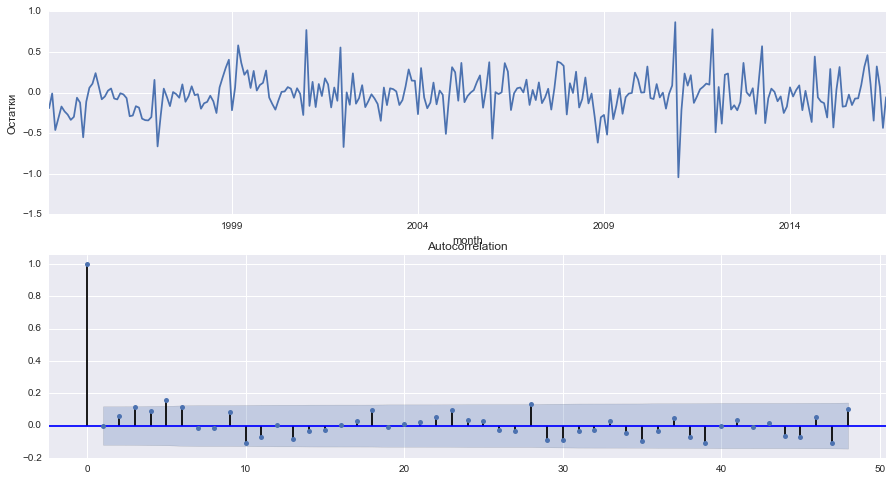

In [60]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1]

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

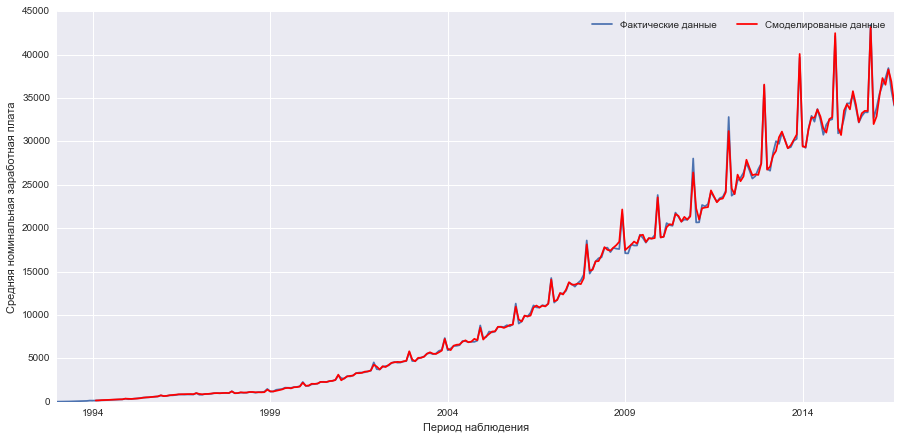

In [72]:
warnings.filterwarnings('ignore')
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
plot1 = df.WAG_C_M.plot()
plot2 = df.model[13:].plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата')
plt.xlabel(u'Период наблюдения')
plt.legend( [u'Фактические данные', u'Смоделированые данные'], loc=1, ncol = 2, prop={'size':10})
pylab.show()
warnings.filterwarnings('default')

Итого: модель описывает данные в приемлемом качестве.

## Прогноз на следующие два года 

Построим график средней номинальной заработной платы и ее прогноз на два следующих года:

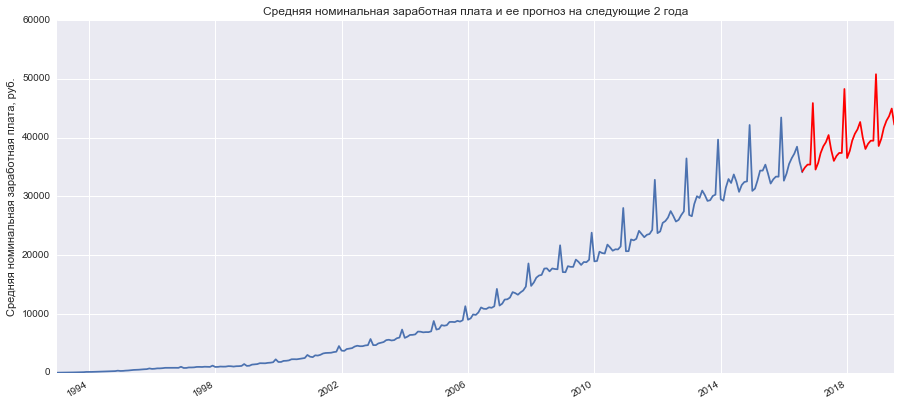

In [73]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel(u'Средняя номинальная заработная плата, руб.')
plt.title(u'Средняя номинальная заработная плата и ее прогноз на следующие 2 года')
pylab.show()

<script type="text/javascript">
    $('div.input').hide();
</script>

<style>
div.prompt {display:none}
</style>